# Abalone

In [6]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/abalone(4177, 8).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'abalone'
file_name = data_name

x_tr = x_tr.toarray().T
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]


x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

of objects: 3341
of features 8
abalone


# K-means cluster centers as inducing inputs

In [8]:
ind_num = 200
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [9]:
cov_params = np.array([1.0, 10., 1.0])

# SVI-L-BFGS-B

In [100]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [101]:
opts = {'maxiter': 100, 'mydisp': True}
svi_res = svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/optimization.py:367: OptimizeWarning: Unknown solver options: mydisp
  out = op.minimize(func, x0, jac=jac, callback=callback, **kwargs)


In [102]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 'i', freq=1)

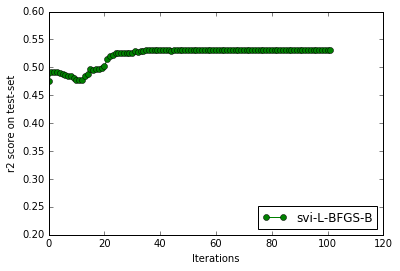

In [103]:
plt.plot(svi_x_lst, svi_y_lst, '-go', label='svi-L-BFGS-B')
plt.ylim([.2, .6])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [104]:
svi_gp.covariance_obj.get_params()

array([[ 10.38521086],
       [ 16.41187267],
       [  0.65608926]])

In [105]:
svi_y_lst[-1]

0.53120857099314533

## VI

In [90]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [91]:
opts = {'maxiter': 10, 'disp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Warning, matrix is not positive definite [ 5.24277282  9.82463069  0.01      ]


In [92]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 'i', freq=1)

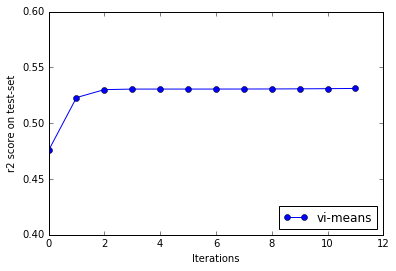

In [93]:
plt.plot(vi_x_lst, vi_y_lst, '-bo', label='vi-means')
plt.ylim([.4, .6])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [106]:
vi_res.params[1]

array([ 4.70066883,  9.82434861,  0.98259311])

In [107]:
vi_y_lst[-1]

0.53114900499971984

## Stochastic SVI
### AdaDelta-Cholesky

In [138]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ch_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SAG')

In [139]:
opts = {'mydisp': True, 'print_freq': 10, 'step_rate': 1.1,
                'maxiter': 300, 'batch_size':200}
ch_svi_res = ch_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Iteration  9 :
	Gradient norm 0.0321447886146
Iteration  19 :
	Gradient norm 0.126865382796
Iteration  29 :
	Gradient norm 0.0405770398574
Iteration  39 :
	Gradient norm 0.411800635598
Iteration  49 :
	Gradient norm 0.0766755942612
Iteration  59 :
	Gradient norm 0.25410424388
Iteration  69 :
	Gradient norm 0.337974705696
Iteration  79 :
	Gradient norm 0.129437239992
Iteration  89 :
	Gradient norm 0.0306514219129
Iteration  99 :
	Gradient norm 0.36922563103
Iteration  109 :
	Gradient norm 0.245699898423
Iteration  119 :
	Gradient norm 0.421262180124
Iteration  129 :
	Gradient norm 0.112334732088
Iteration  139 :
	Gradient norm 0.206723078273
Iteration  149 :
	Gradient norm 0.353144710469
Iteration  159 :
	Gradient norm 0.290981377192
Iteration  169 :
	Gradient norm 0.0188633087448
Iteration  179 :
	Gradient norm 0.311916200777
Iteration  189 :
	Gradient norm 0.143262522896
Iteration  199 :
	Gradient norm 0.0370502217028
Iteration  209 :
	Gradient norm 0.33862919341
Iteration  219 :
	Gra

In [140]:
metric = lambda w: ch_svi_gp.get_prediction_quality(w, x_test, y_test)
ch_svi_x_lst, ch_svi_y_lst = ch_svi_res.plot_performance(metric, 'i', freq=5)

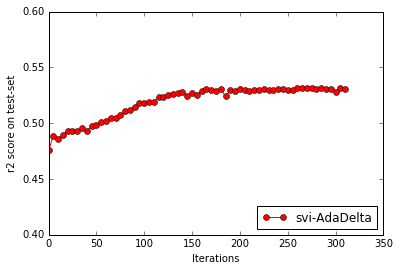

In [141]:
plt.plot(ch_svi_x_lst, ch_svi_y_lst, '-ro', label='svi-AdaDelta')
plt.ylim([.4, .6])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [142]:
ch_svi_gp.covariance_obj.get_params()

array([[  6.07274827],
       [ 11.84986435],
       [  0.62200226]])

In [143]:
ch_svi_y_lst[-1]

0.53068055758850285

### SG-Natural

In [43]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
# model_covariance_obj = SquaredExponential(np.array([5., 10., 0.6]))
n_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural')

In [44]:
opts = {'maxiter':1000, 'batch_size': 3341 , 'print_freq': 10, 'step0': 1e-4, 'gamma': 0.51}
n_svi_res = n_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.0001
	Parameters [ 1.02045278  9.99835685]
Epoch  10 :
	Step: 3.09029543251e-05
	Parameters [ 1.08888453  9.99393952]
Epoch  20 :
	Step: 2.17007479236e-05
	Parameters [ 1.11202825  9.99269894]
Epoch  30 :
	Step: 1.76468892492e-05
	Parameters [ 1.12714999  9.99206354]
Epoch  40 :
	Step: 1.52387521105e-05
	Parameters [ 1.13795155  9.99175903]
Epoch  50 :
	Step: 1.35995737892e-05
	Parameters [ 1.14781788  9.99142614]
Epoch  60 :
	Step: 1.23920415894e-05
	Parameters [ 1.15681828  9.99108141]
Epoch  70 :
	Step: 1.14551294037e-05
	Parameters [ 1.16293072  9.99099489]
Epoch  80 :
	Step: 1.07009936571e-05
	Parameters [ 1.16824725  9.99090945]
Epoch  90 :
	Step: 1.00771174463e-05
	Parameters [ 1.17313707  9.99090498]
Epoch  100 :
	Step: 9.54992586021e-06
	Parameters [ 1.17746246  9.99090669]
Epoch  110 :
	Step: 9.0968227066e-06
	Parameters [ 1.18251534  9.99080153]
Epoch  120 :
	Step: 8.70196965505e-06
	Parameters [ 1.18682312  9.99073065]
Epoch  130 :
	Step: 8.3538926533e-0

In [45]:
metric = lambda w: n_svi_gp.get_prediction_quality(w, x_test, y_test)
n_svi_x_lst, n_svi_y_lst = n_svi_res.plot_performance(metric, 'i', freq=1)

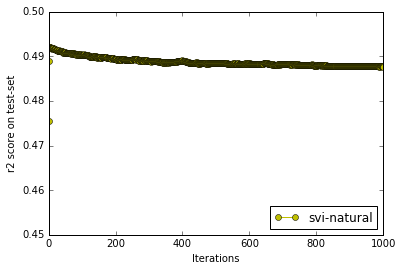

In [46]:
plt.plot(n_svi_x_lst, n_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([.45, .5])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

# Save results

In [18]:
np.save('../plots/regression_revision/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/regression_revision/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/regression_revision/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/regression_revision/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/regression_revision/'+ data_name +'_ad_x.npy', ch_svi_x_lst)
np.save('../plots/regression_revision/'+ data_name +'_ad_y.npy', ch_svi_y_lst)
np.save('../plots/regression_revision/'+ data_name +'_sg_x.npy', n_svi_x_lst)
np.save('../plots/regression_revision/'+ data_name +'_sg_y.npy', n_svi_y_lst)

#SVM test

In [3]:
svm = SVR(C=0.5)
svm.fit(x_tr.T, y_tr[:, 0])

SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [4]:
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.54035268099230693